In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Load and preprocess the time series data
data = pd.read_csv('Temp_at_ZoneA.csv')  # Replace 'Temp_BCK.csv' with your actual data file
data.columns = ['Date', 'Temp']  # Define column names

series = data['Temp'].values.reshape(-1, 1)  # Assuming your data has a 'Temp' column

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(series)

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.6)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create input sequences and corresponding target values
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

seq_length = 10  # Length of input sequences
train_x, train_y = create_sequences(train_data, seq_length)
test_x, test_y = create_sequences(test_data, seq_length)

# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='sigmoid', input_shape=(seq_length, 1)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

# Train the LSTM model
model_lstm.fit(train_x, train_y, epochs=20, batch_size=32)

# Make predictions using the LSTM model
predictions_lstm = model_lstm.predict(test_x)

# Reshape the data for ARIMA and XGBoost models
train_y_ar = train_y.reshape(-1)
test_y_ar = test_y.reshape(-1)

# Define and fit the ARIMA model
model_arima = ARIMA(train_y_ar, order=(2, 0, 0))
model_arima_fit = model_arima.fit()

# Make predictions using the ARIMA model
predictions_arima = model_arima_fit.predict(start=len(train_y_ar), end=len(train_y_ar) + len(test_y_ar) - 1)

# Reshape the input features for XGBoost
train_x_2d = train_x.reshape(train_x.shape[0], -1)
test_x_2d = test_x.reshape(test_x.shape[0], -1)

# Define and fit the XGBoost model
model_xg = XGBRegressor(n_estimators=100, max_depth=6, min_child_weight=1, learning_rate=0.1,
                        subsample=0.8, colsample_bytree=0.8)
model_xg.fit(train_x_2d, train_y_ar)

# Make predictions using the XGBoost model
predictions_xg = model_xg.predict(test_x_2d)

# Calculate the mean squared error
mse_lstm = mean_squared_error(test_y_ar, predictions_lstm)
mse_arima = mean_squared_error(test_y_ar, predictions_arima)
mse_xg = mean_squared_error(test_y_ar, predictions_xg)

print('LSTM MSE:', mse_lstm)
print('ARIMA MSE:', mse_arima)
print('XGBoost MSE:', mse_xg)


Epoch 1/20
3759/3759 [==============================] - 27s 7ms/step - loss: 0.0191
Epoch 2/20
3759/3759 [==============================] - 25s 7ms/step - loss: 4.8047e-04
Epoch 3/20
3759/3759 [==============================] - 25s 7ms/step - loss: 1.5701e-04
Epoch 4/20
3759/3759 [==============================] - 27s 7ms/step - loss: 1.5576e-04
Epoch 5/20
3759/3759 [==============================] - 25s 7ms/step - loss: 1.5412e-04
Epoch 6/20
3759/3759 [==============================] - 25s 7ms/step - loss: 1.5357e-04
Epoch 7/20
3759/3759 [==============================] - 25s 7ms/step - loss: 1.5140e-04
Epoch 8/20
3759/3759 [==============================] - 26s 7ms/step - loss: 1.4653e-04
Epoch 9/20
3759/3759 [==============================] - 24s 6ms/step - loss: 1.4766e-04
Epoch 10/20
3759/3759 [==============================] - 23s 6ms/step - loss: 1.4358e-04
Epoch 11/20
3759/3759 [==============================] - 24s 6ms/step - loss: 1.4286e-04
Epoch 12/20
3759/3759 [===========

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LSTM MSE: 0.00015622866941815685
ARIMA MSE: 0.0010350105757290019
XGBoost MSE: 0.00013703114952589115


Temperature Prediction using LSTM

In [ ]:
# Make predictions for LSTM
train_predictions = model_lstm.predict(train_x)
test_predictions = model_lstm.predict(test_x)

# Inverse scale the predictions for interpretation
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
test_actual = scaler.inverse_transform(test_y)
print('Predicted Test Values:')
print('Temperature Predicted Value:',test_predictions[0:10])
print('Temperature Actual Value:',test_actual[0:10])


2280/2280 [==============================] - 5s 2ms/step
Predicted Test Values:
Temperature Predicted Value: [[22.226387]
 [22.235067]
 [22.242462]
 [22.248657]
 [22.253965]
 [22.257845]
 [22.261564]
 [22.261564]
 [22.261564]
 [22.261564]]
Temperature Actual Value: [[22.5]
 [22.5]
 [22.5]
 [22.5]
 [22.5]
 [22.5]
 [22.5]
 [22.5]
 [22.5]
 [22.5]]


Temperature Prediction graph using LSTM

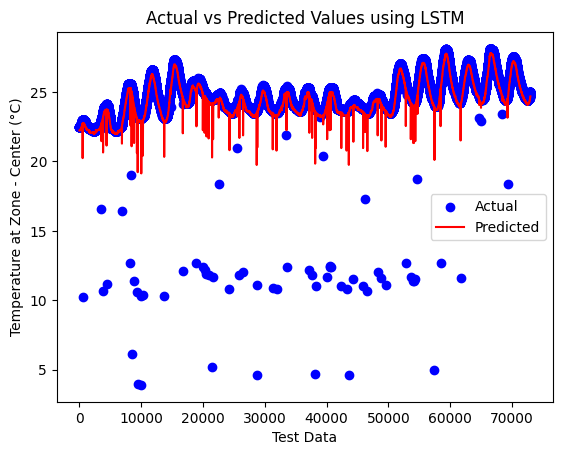

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the actual values and predicted values
#actual_values = scaler.inverse_transform(test_y_ar)# Replace with your actual values
actual_values  = test_actual
predicted_values = test_predictions  # Replace with your predicted values

# Create a time axis for the x-axis of the plot
time_axis = range(len(actual_values))


# Plot the actual values as blue dots
plt.scatter(time_axis, actual_values, color='blue', label='Actual')

# Plot the predicted values as red line
plt.plot(time_axis, predicted_values, color='red', label='Predicted')

# Set labels and title for the plot
plt.xlabel('Test Data')
plt.ylabel('Temperature at Zone - Center (°C)')
plt.title('Actual vs Predicted Values using LSTM')
plt.legend()

# Display the plot
plt.show()

Using ARIMA Model

In [ ]:


# Make predictions for ARIMA
train_predictions = model_arima_fit.predict(start=0, end=len(train_y_ar)-1)
test_predictions = model_arima_fit.predict(start=len(train_y_ar), end=len(train_y_ar) + len(test_y_ar) - 1)


test_y_ar = test_y_ar.reshape(-1,1)  # Reshaping from 1D into 2D
train_predictions = train_predictions.reshape(-1,1)
test_predictions= test_predictions.reshape(-1,1)

# Inverse scale the predictions for interpretation
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
test_actual = scaler.inverse_transform(test_y_ar)
print('Predicted Test Values:')
print('Temperature Predicted Value:',test_predictions[0:10])
print('Temperature Actual Value:',test_actual[0:10])

Predicted Test Values:
Temperature Predicted Value: [[22.41409454]
 [22.42108539]
 [22.43149978]
 [22.44011078]
 [22.44951469]
 [22.45842303]
 [22.46747639]
 [22.47635742]
 [22.48522444]
 [22.49399959]]
Temperature Actual Value: [[22.5]
 [22.5]
 [22.5]
 [22.5]
 [22.5]
 [22.5]
 [22.5]
 [22.5]
 [22.5]
 [22.5]]


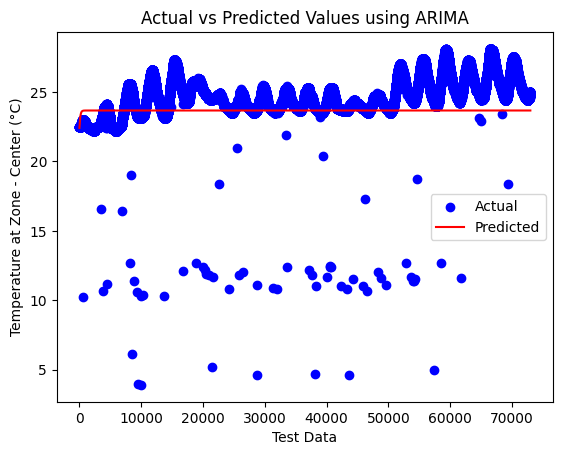

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the actual values and predicted values
#actual_values = scaler.inverse_transform(test_y_ar)# Replace with your actual values
actual_values  = test_actual
predicted_values = test_predictions  # Replace with your predicted values

# Create a time axis for the x-axis of the plot
time_axis = range(len(actual_values))


# Plot the actual values as blue dots
plt.scatter(time_axis, actual_values, color='blue', label='Actual')

# Plot the predicted values as red line
plt.plot(time_axis, predicted_values, color='red', label='Predicted')

# Set labels and title for the plot
plt.xlabel('Test Data')
plt.ylabel('Temperature at Zone - Center (°C)')
plt.title('Actual vs Predicted Values using ARIMA')
plt.legend()

# Display the plot
plt.show()

Using XGBoost model

In [ ]:
# Make predictions for XGBoost Model
train_predictions = model_xg.predict(train_x_2d)
test_predictions = model_xg.predict(test_x_2d)

train_predictions = train_predictions.reshape(-1,1)
test_predictions = test_predictions.reshape(-1,1)

# Inverse scale the predictions for interpretation
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
test_actual = scaler.inverse_transform(test_y_ar)
print('Predicted Test Values:')
print('Temperature Predicted Value:',test_predictions[0:10])
print('Temperature Actual Value:',test_actual[0:10])



Predicted Test Values:
Temperature Predicted Value: [[22.464537]
 [22.478449]
 [22.467516]
 [22.481373]
 [22.493105]
 [22.494558]
 [22.493382]
 [22.493382]
 [22.493382]
 [22.493382]]
Temperature Actual Value: [[22.5]
 [22.5]
 [22.5]
 [22.5]
 [22.5]
 [22.5]
 [22.5]
 [22.5]
 [22.5]
 [22.5]]


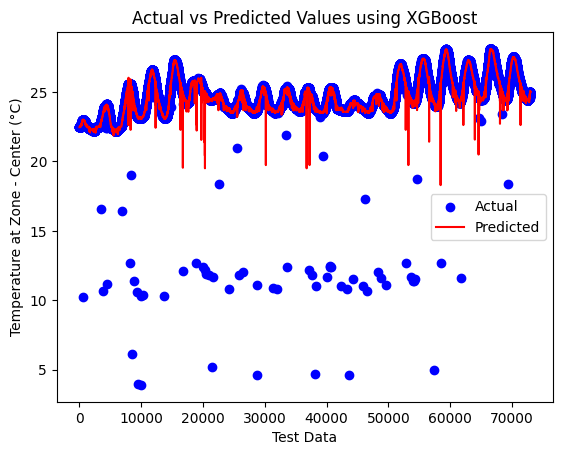

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the actual values and predicted values
#actual_values = scaler.inverse_transform(test_y_ar)# Replace with your actual values
actual_values  = test_actual
predicted_values = test_predictions  # Replace with your predicted values

# Create a time axis for the x-axis of the plot
time_axis = range(len(actual_values))


# Plot the actual values as blue dots
plt.scatter(time_axis, actual_values, color='blue', label='Actual')

# Plot the predicted values as red line
plt.plot(time_axis, predicted_values, color='red', label='Predicted')

# Set labels and title for the plot
plt.xlabel('Test Data')
plt.ylabel('Temperature at Zone - Center (°C)')
plt.title('Actual vs Predicted Values using XGBoost')
plt.legend()

# Display the plot
plt.show()

GRU MODEL

In [ ]:
##### Step 3 - Specify the structure of a Neural Network
from keras import Input # for instantiating a keras tensor
from keras.layers import Bidirectional, GRU, RepeatVector, Dense, TimeDistributed # for creating layers inside the Neural Network


model_GRU = Sequential(name="GRU-Model") # Model
model_GRU.add(Input(shape=(train_x.shape[1],train_x.shape[2]), name='Input-Layer')) # Input Layer - need to speicfy the shape of inputs
model_GRU.add(Bidirectional(GRU(units=32, activation='tanh', recurrent_activation='sigmoid', stateful=False), name='Hidden-GRU-Encoder-Layer')) # Encoder Layer
model_GRU.add(RepeatVector(train_x.shape[1], name='Repeat-Vector-Layer')) # Repeat Vector
model_GRU.add(Bidirectional(GRU(units=32, activation='tanh', recurrent_activation='sigmoid', stateful=False, return_sequences=True), name='Hidden-GRU-Decoder-Layer')) # Decoder Layer
model_GRU.add(TimeDistributed(Dense(units=1, activation='linear'), name='Output-Layer')) # Output Layer, Linear(x) = x


##### Step 4 - Compile the model
model_GRU.compile(optimizer='adam', # default='rmsprop', an algorithm to be used in backpropagation
              loss='mean_squared_error', # Loss function to be optimized. A string (name of loss function), or a tf.keras.losses.Loss instance.
              metrics=['MeanSquaredError', 'MeanAbsoluteError'], # List of metrics to be evaluated by the model during training and testing. Each of this can be a string (name of a built-in function), function or a tf.keras.metrics.Metric instance.
              loss_weights=None, # default=None, Optional list or dictionary specifying scalar coefficients (Python floats) to weight the loss contributions of different model outputs.
              weighted_metrics=None, # default=None, List of metrics to be evaluated and weighted by sample_weight or class_weight during training and testing.
              run_eagerly=None, # Defaults to False. If True, this Model's logic will not be wrapped in a tf.function. Recommended to leave this as None unless your Model cannot be run inside a tf.function.
              steps_per_execution=None # Defaults to 1. The number of batches to run during each tf.function call. Running multiple batches inside a single tf.function call can greatly improve performance on TPUs or small models with a large Python overhead.
             )


##### Step 5 - Fit the model on the dataset
history = model_GRU.fit(train_x, # input data
                    train_y, # target data
                    batch_size=1, # Number of samples per gradient update. If unspecified, batch_size will default to 32.
                    epochs=20, # default=1, Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided
                    verbose=1, # default='auto', ('auto', 0, 1, or 2). Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch. 'auto' defaults to 1 for most cases, but 2 when used with ParameterServerStrategy.
                    validation_split=0.4, # default=0.0, Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch.
                    #validation_data=(X_test, y_test), # default=None, Data on which to evaluate the loss and any model metrics at the end of each epoch.
                    shuffle=True, # default=True, Boolean (whether to shuffle the training data before each epoch) or str (for 'batch').
                    initial_epoch=0, # Integer, default=0, Epoch at which to start training (useful for resuming a previous training run)
                    validation_freq=10, # default=1, Only relevant if validation data is provided. If an integer, specifies how many training epochs to run before a new validation run is performed, e.g. validation_freq=2 runs validation every 2 epochs.
                    max_queue_size=10, # default=10, Used for generator or keras.utils.Sequence input only. Maximum size for the generator queue. If unspecified, max_queue_size will default to 10.
                    workers=1, # default=1, Used for generator or keras.utils.Sequence input only. Maximum number of processes to spin up when using process-based threading. If unspecified, workers will default to 1.
                    use_multiprocessing=True, # default=False, Used for generator or keras.utils.Sequence input only. If True, use process-based threading. If unspecified, use_multiprocessing will default to False.
                   )


##### Step 6 - Use model to make predictions
pred_test = model_GRU.predict(test_x)


##### Step 7 - Print Performance Summary
print("")
print('-------------------- Model Summary --------------------')
model_GRU.summary() # print model summary
print("")
print('-------------------- Weights and Biases --------------------')
print("Too many parameters to print but you can use the code provided if needed")
print("")

# Print the last value in the evaluation metrics contained within history file
print('-------------------- Evaluation on Training Data --------------------')
for item in history.history:
    print("Final", item, ":", history.history[item][-1])
print("")

# Evaluate the model on the test data using "evaluate"
print('-------------------- Evaluation on Test Data --------------------')
results = model_GRU.evaluate(test_x, test_y)
print("")

Epoch 1/20
65662/65662 [==============================] - 509s 8ms/step - loss: 2.1507e-04 - mean_squared_error: 2.1507e-04 - mean_absolute_error: 0.0039
Epoch 2/20
65662/65662 [==============================] - 500s 8ms/step - loss: 1.3904e-04 - mean_squared_error: 1.3904e-04 - mean_absolute_error: 0.0027
Epoch 3/20
65662/65662 [==============================] - 494s 8ms/step - loss: 1.3216e-04 - mean_squared_error: 1.3216e-04 - mean_absolute_error: 0.0023
Epoch 4/20
65662/65662 [==============================] - 463s 7ms/step - loss: 1.2599e-04 - mean_squared_error: 1.2599e-04 - mean_absolute_error: 0.0021
Epoch 5/20
65662/65662 [==============================] - 469s 7ms/step - loss: 1.2334e-04 - mean_squared_error: 1.2334e-04 - mean_absolute_error: 0.0020
Epoch 6/20
65662/65662 [==============================] - 457s 7ms/step - loss: 1.1972e-04 - mean_squared_error: 1.1972e-04 - mean_absolute_error: 0.0019
Epoch 7/20
65662/65662 [==============================] - 456s 7ms/step - lo

In [ ]:
# Make predictions for XGBoost Model
train_predictions = model_GRU.predict(train_x)
test_predictions = model_GRU.predict(test_x)

train_predictions = train_predictions.reshape(-1,1)
test_predictions = test_predictions.reshape(-1,1)

# Inverse scale the predictions for interpretation
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
test_actual = scaler.inverse_transform(test_y)
print('Predicted Test Values:')
print('Temperature Predicted Value:',test_predictions[0:10])
print('Temperature Actual Value:',test_actual[0:10])



In [ ]:
# Assuming you have the actual values and predicted values
#actual_values = scaler.inverse_transform(test_y_ar)# Replace with your actual values
actual_values  = test_actual
predicted_values = test_predictions  # Replace with your predicted values

# Create a time axis for the x-axis of the plot
time_axis = range(len(actual_values))


# Plot the actual values as blue dots
plt.scatter(time_axis, actual_values, color='blue', label='Actual')

# Plot the predicted values as red line
plt.plot(time_axis, predicted_values, color='red', label='Predicted')

# Set labels and title for the plot
plt.xlabel('Test Data')
plt.ylabel('Temperature')
plt.title('Actual vs Predicted Values using GRU')
plt.legend()